In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

データの作成

In [6]:
def generate_sample_data(num: int, seed: int = 0) -> pd.DataFrame:
    target_list = []
    feature_vector_list = []

    feature_num = 8 #特徴量の数
    intercept = 0.2 #切片 b: w0
    weight = [0.2, 0.3, 0.5, -0.4, 0.1, 0.2, 0.5, -0.3] #特徴量の重み W: w1-w8

    np.random.seed(seed=seed)
    for i in range(num):
        feature_vector = [np.random.rand()        for n in range(feature_num)] #特徴量をランダムに生成
        noise          = [np.random.normal(0,0.1) for n in range(feature_num)] #Norm(0, 0.1)のノイズをランダムに生成
        target: float  = sum([
                                intercept + feature_vector[n]*weight[n]+noise[n] for n in range(feature_num)
                            ]) #目的変数を計算
        target_list.append(target)
        feature_vector_list.append(feature_vector)
    
    # num * feature_num 行列
    df = pd.DataFrame(np.c_[target_list, feature_vector_list],
                      columns=["target",   "feature0", "feature1", "feature2", 
                               "feature3", "feature4", "feature5", "feature6", "feature7"])
    return df


In [9]:
data = generate_sample_data(num=1000, seed=0)

train_cols = [col for col in data.columns if col is not "target"]
X = data[train_cols]
y = data["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-9-656ab46b593a>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  train_cols = [col for col in data.columns if col is not "target"]


PyStanの実装

In [10]:
import pystan
import arviz

In [12]:
sample_code = """
    data {
        int<lower=0> N;
        int<lower=0> D;
        matrix[N, D] X;
        vector[N] y;
        int<lower=0> N_new;
        matrix[N_new, D] X_new;
    }
    parameters {
        real w0;
        vector[D] w;
        real<lower=0> sigma;
    }
    model {
        for (i in 1:N)
            y[i] ~ normal(w0 + dot_product(X[i], w), sigma);
    }
    generated quantities {
        vector[N_new] y_new;
        for (i in 1:N_new)
            y_new[i] = normal_rng(w0 + dot_product(X_new[i], w), sigma);
    }
"""

sample_data = {
    'N':     X_train.shape[0], # number of TrainData
    'D':     X_train.shape[1], # number of Features
    'X':     X_train,          # train_X 
    'y':     y_train,          # train_y
    'N_new': X_test.shape[0],  # number of TestData
    'X_new': X_test            # test_X
}

In [13]:
sm = pystan.StanModel(model_code=sample_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_92cd13fa4b6e158fdf4f4ede934e6196 NOW.


In [17]:
fit = sm.sampling(data=sample_data, iter=5000, chains=4)
print(fit)

Inference for Stan model: anon_model_92cd13fa4b6e158fdf4f4ede934e6196.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w0            1.6  5.3e-4   0.05   1.51   1.57    1.6   1.64    1.7   8320    1.0
w[1]         0.19  2.9e-4   0.03   0.12   0.16   0.19   0.21   0.25  13184    1.0
w[2]         0.35  2.8e-4   0.03   0.28   0.33   0.35   0.37   0.42  13413    1.0
w[3]          0.5  2.8e-4   0.03   0.43   0.48    0.5   0.52   0.56  14153    1.0
w[4]        -0.41  3.0e-4   0.03  -0.48  -0.44  -0.41  -0.39  -0.35  12488    1.0
w[5]         0.08  2.9e-4   0.03   0.02   0.06   0.08   0.11   0.15  13001    1.0
w[6]         0.21  3.0e-4   0.03   0.15   0.19   0.21   0.24   0.28  12756    1.0
w[7]         0.47  2.9e-4   0.03    0.4   0.45   0.47   0.49   0.54  13792    1.0
w[8]        -0.33  2.9e-4   0.03  -0.39  -0.35  -0.33   -0.3  -0.26  136

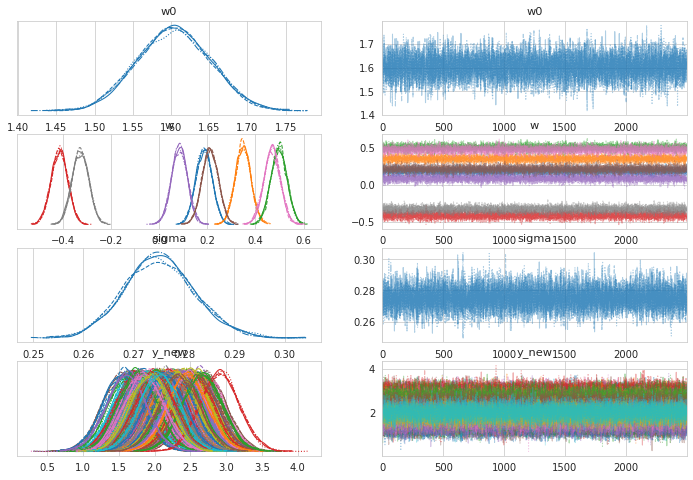

In [18]:
arviz.plot_trace(fit)
plt.show()

In [20]:
y_pred = fit['y_new'].mean(axis=0)
print('MSE(test) = {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('R^2(test) = {:.2f}'.format(r2_score(y_test, y_pred)))

MSE(test) = 0.07
R^2(test) = 0.50
